# **04 - Modelling**

## Objectives

* Augment the training dataset to provide the model more data to train on.
* Build a model architecture based on a convolutional neural network, that outputs a probability for a given leaf having powdery mildew or not.
* Fit the model to the training data.

## Inputs

* inputs/cherry_leaves_dataset/cherry-leaves/train
* inputs/cherry_leaves_dataset/cherry-leaves/validation

## Outputs

* Image montage showing a sample of the augmented training data.
* plot indicating the architecture of the convolutional neural network.
* Plot indicating the learning curve of the model in training.
* Model.h5

## Additional Comments

* No additional comments. 



---

# Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import joblib

from matplotlib.image import imread

---

# Set Data directory variables

## Change working directory

* Change the working directory from the current folder to /workspace/Mildew-Detection-in-Cherry-Leaves

* The output from the cell bellow should be '/workspace/Mildew-Detection-in-Cherry-Leaves'

In [2]:
os.chdir(os.path.dirname(os.getcwd()))
current_dir = os.getcwd()
current_dir

'/workspace/Mildew-Detection-in-Cherry-Leaves'

## Input directory variables

In [3]:
data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_data_dir = data_dir + '/train'
val_data_dir = data_dir + '/validation'
test_data_dir = data_dir + '/test'

## Output directory variables

In [4]:
# declare the name of your output folder
output_dir = 'current_output'

In [5]:
if 'outputs' not in os.listdir(current_dir):
    os.makedirs(name='outputs')

def create_output_dir(output_dir):
    try:
        os.makedirs(name=f'outputs/{output_dir}')
        print(f'Current output folder is {output_dir}')
        return f'outputs/{output_dir}'
    except:
        print(f'Current output folder is {output_dir}. Note that this is an already existing folder.')
        return f'outputs/{output_dir}'
version_output = create_output_dir(output_dir)

Current output folder is current_output. Note that this is an already existing folder.


## Data label names variables

In [6]:
labels = os.listdir(train_data_dir)
print(f'Datalabels are {labels}')

Datalabels are ['healthy', 'powdery_mildew']


## Set image shape

* As seen in notebook "01 - DataCollection" all images are 256 X 256 pixels 

* To control model performance/model size this model_shape variable might need to be set based on trial and error.

In [7]:
#As images are squares (checked in data collection notebook), we set only one variable to control both height and width
height_width = 75
#channel value set to 3 corresponding with RGB
channels = 3

img_shape = (height_width, height_width, channels)
img_shape

(75, 75, 3)

---

# Augment data

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
augment_training_data = ImageDataGenerator(rotation_range=90,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

In [10]:
batch_size = 20  # Set batch size
augmented_training_data = augment_training_data.flow_from_directory(train_data_dir,
                                                     target_size=img_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

augmented_training_data.class_indices

Found 2948 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [11]:
validation_data_object = ImageDataGenerator(rescale=1./255).flow_from_directory(val_data_dir,
                                                                        target_size=img_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_data_object.class_indices

Found 422 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [12]:
test_data_object = ImageDataGenerator(rescale=1./255).flow_from_directory(test_data_dir,
                                                                        target_size=img_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

test_data_object.class_indices

Found 838 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

(20, 75, 75, 3)


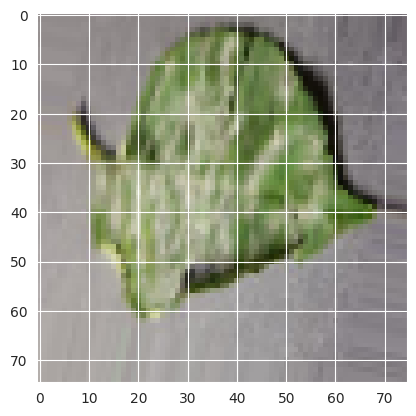

(20, 75, 75, 3)


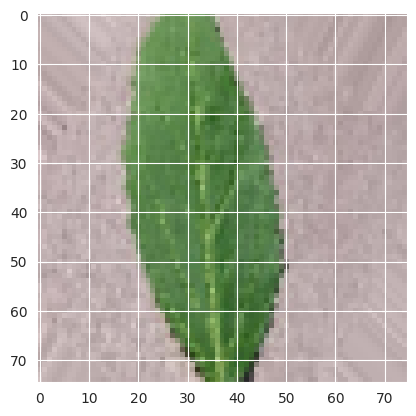

(20, 75, 75, 3)


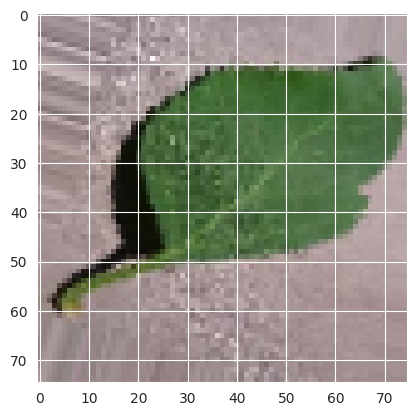

In [13]:
for _ in range(3):
    img, label = augmented_training_data.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

---

# Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras import regularizers


In [15]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(5, 5),
          input_shape=img_shape, activation='relu', ))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(5, 5),
          input_shape=img_shape, activation='relu', ))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(5, 5),
          input_shape=img_shape, activation='relu', ))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


2023-06-12 10:02:13.836486: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 71, 71, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 35, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 31, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 16)        12816     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [18]:
model.fit(augmented_training_data,
          epochs=25,
          validation_data=validation_data_object,
          callbacks=[early_stop],
          verbose=1
          )

2023-06-12 10:02:14.263034: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
148/148 [==============================] - 8s 55ms/step - loss: 1.1210 - accuracy: 0.7541 - val_loss: 0.3749 - val_accuracy: 0.9479
Epoch 2/25
148/148 [==============================] - 8s 52ms/step - loss: 0.3561 - accuracy: 0.9186 - val_loss: 0.2068 - val_accuracy: 0.9763
Epoch 3/25
148/148 [==============================] - 8s 53ms/step - loss: 0.2603 - accuracy: 0.9417 - val_loss: 0.1604 - val_accuracy: 0.9834
Epoch 4/25
148/148 [==============================] - 8s 52ms/step - loss: 0.1843 - accuracy: 0.9617 - val_loss: 0.1213 - val_accuracy: 0.9905
Epoch 5/25
148/148 [==============================] - 8s 52ms/step - loss: 0.1518 - accuracy: 0.9657 - val_loss: 0.2118 - val_accuracy: 0.9455
Epoch 6/25
148/148 [==============================] - 8s 52ms/step - loss: 0.1139 - accuracy: 0.9752 - val_loss: 0.0947 - val_accuracy: 0.9905
Epoch 7/25
148/148 [==============================] - 8s 52ms/step - loss: 0.1090 - accuracy: 0.9769 - val_loss: 0.0810 - val_accuracy: 0.9882

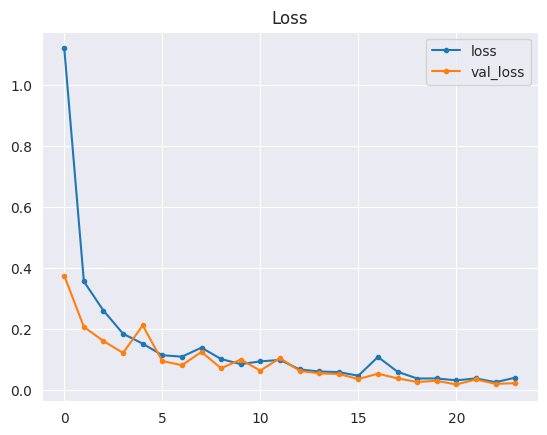

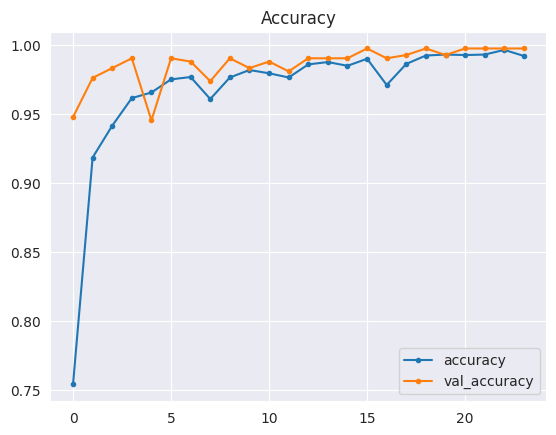

In [19]:
losses = pd.DataFrame(model.history.history)


losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{version_output}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{version_output}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Evaluation

In [20]:
evaluation = model.evaluate(test_data_object)

42/42 [==============================] - 1s 14ms/step - loss: 0.0207 - accuracy: 0.9988


In [21]:
from sklearn.metrics import classification_report, confusion_matrix
label_map= [str(label) for label in labels]

def create_evaluation_report(data_object, data_name):

    img_arrays = []
    labels = []
    i = 0
    while i < data_object.n:
        x_batch, y_batch = data_object.next()
        img_arrays.append(x_batch)
        labels.append(y_batch)
        i += x_batch.shape[0]
    img_arrays = np.concatenate(img_arrays, axis=0)
    labels = np.concatenate(labels, axis=0)

    prediction = model.predict(img_arrays)
    prediction_binary = np.argmax(prediction, axis=1)
    labels_binary = np.argmax(labels, axis=1)

    false_predictions = []
    for j in range(len(prediction_binary)):
        if prediction_binary[j] != labels_binary[j]:
            false_predictions.append([j, prediction[j]])

    print(f'---  Confusion Matrix for {data_name}')
    print(pd.DataFrame(confusion_matrix(y_true=prediction_binary, y_pred=labels_binary),
          columns=[ ["Actual " + sub for sub in label_map] ], 
          index= [ ["Prediction " + sub for sub in label_map ]]
          ))
    print("\n")

    print(f'---  Classification Report for {data_name}')
    print(classification_report(labels_binary, prediction_binary, target_names=label_map),"\n")
    print("\n")
    print("\n")
    return prediction, false_predictions


In [22]:
import sys

# Specify the directory and file path for model_summary.txt
file_path = f"{version_output}/evaluation_reports.txt"

# Save the model summary to the specified file
with open(file_path, "w") as file:
    stdout_original = sys.stdout
    sys.stdout = file
    predicted_training = create_evaluation_report(augmented_training_data, 'TRAINING DATA')
    predicted_validation = create_evaluation_report(validation_data_object, 'VALIDATION DATA')
    predicted_test = create_evaluation_report(test_data_object, 'TEST DATA')
    sys.stdout = stdout_original

In [23]:
predicted_training = create_evaluation_report(augmented_training_data, 'TRAINING DATA')
predicted_validation = create_evaluation_report(validation_data_object, 'VALIDATION DATA')
predicted_test = create_evaluation_report(test_data_object, 'TEST DATA')

---  Confusion Matrix for TRAINING DATA
                          Actual healthy Actual powdery_mildew
Prediction healthy                  1459                     1
Prediction powdery_mildew             11                  1477


---  Classification Report for TRAINING DATA
                precision    recall  f1-score   support

       healthy       1.00      0.99      1.00      1470
powdery_mildew       0.99      1.00      1.00      1478

      accuracy                           1.00      2948
     macro avg       1.00      1.00      1.00      2948
  weighted avg       1.00      1.00      1.00      2948
 





---  Confusion Matrix for VALIDATION DATA
                          Actual healthy Actual powdery_mildew
Prediction healthy                   211                     1
Prediction powdery_mildew              0                   210


---  Classification Report for VALIDATION DATA
                precision    recall  f1-score   support

       healthy       1.00      1.00      1

Probability distribution report for TRAINING dataset
_____________________________________________________________
75% of false predictions have an output probability of 91.14 or lower
1.05% of all predictions have a probability below the 75th percentile of false predictions
I.e 75% of all false predictions are found in the 1.05% of data with the lowest probability


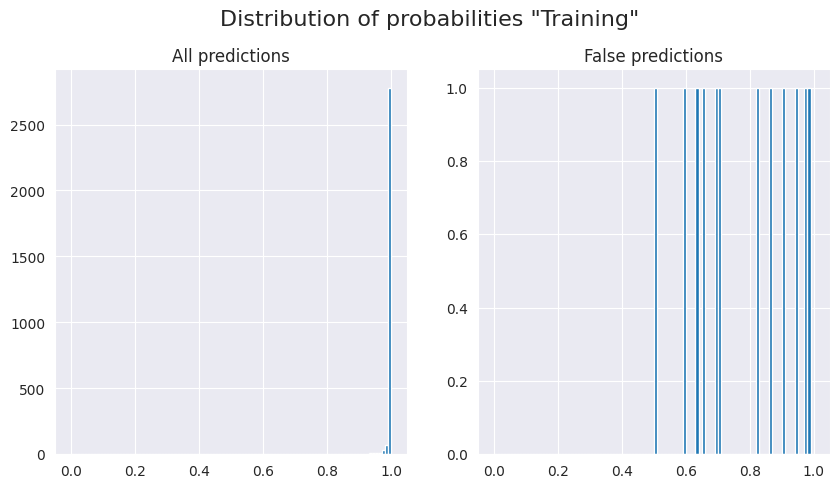

Probability distribution report for VALIDATION dataset
_____________________________________________________________
75% of false predictions have an output probability of 94.95 or lower
1.42% of all predictions have a probability below the 75th percentile of false predictions
I.e 75% of all false predictions are found in the 1.42% of data with the lowest probability


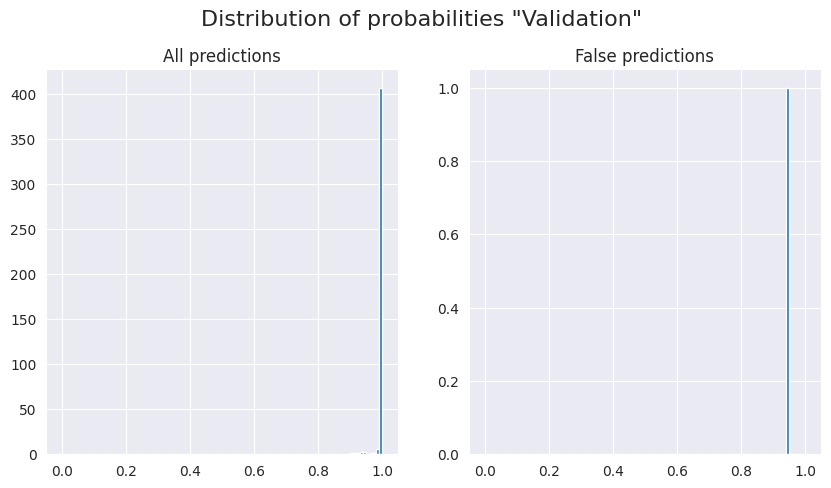

Probability distribution report for TEST dataset
_____________________________________________________________
75% of false predictions have an output probability of 98.09 or lower
2.03% of all predictions have a probability below the 75th percentile of false predictions
I.e 75% of all false predictions are found in the 2.03% of data with the lowest probability


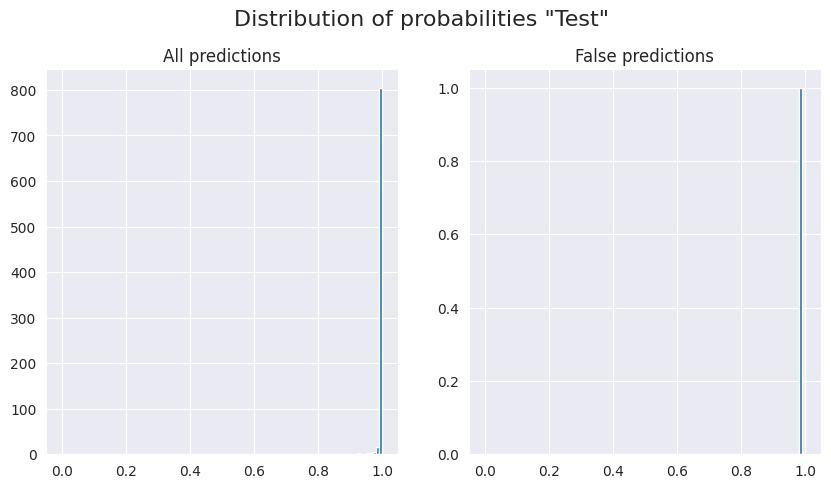

In [24]:
from statistics import median


def check_probability_meaning(predicted_set, data_object, name):
    
    proba_for_all_pred = []
    n_predictions_below_threshold = []
    proba_for_false_pred = []

    for false_pred in predicted_set[1]:
        proba_for_false_pred.append(1 - min(false_pred[1]))

    #Calculate the 75th percentile of the probabilities false predictions
    # i.e where 75% of false predictions are below this probability
    threshold = np.quantile(proba_for_false_pred, [0.75])[0]

    #Collect all predictions that have a probability below the 75th percentile of false predictions
    for pred in predicted_set[0]:
        proba_for_all_pred.append(abs(1 - min(pred)))
        if abs(1 - min(pred)) < threshold:
            n_predictions_below_threshold.append(pred)

    

    #Calculate the % of predictions that are below the 75th percentile of false prediction
    ratio = round(((len(n_predictions_below_threshold) / data_object.n)*100),2)

    print(f'Probability distribution report for {name.upper()} dataset')
    print('_____________________________________________________________')
    print(f'75% of false predictions have an output probability of {round(threshold*100, 2)} or lower')
    print(f'{ratio}% of all predictions have a probability below the 75th percentile of false predictions')
    print(f'I.e 75% of all false predictions are found in the {ratio}% of data with the lowest probability')
    
    #Create figure to plot distribution of predictions across probabilities
    bin = []
    for i in range(0, 101):
        if i == 0 :
            bin.append(0)
        else:
            bin.append(i/100)

    fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
    axes[0].hist(proba_for_all_pred, bins=bin)
    axes[0].set_title('All predictions')
    axes[1].hist(proba_for_false_pred, bins=bin)
    axes[1].set_title('False predictions')
    fig.suptitle(f'Distribution of probabilities "{name}"', fontsize=16, y=1)
    plt.savefig(f'{version_output}/proba_dist_{name.lower()}.png',
            bbox_inches='tight', dpi=150)
    plt.show()

check_probability_meaning(predicted_training, augmented_training_data, 'Training')
check_probability_meaning(predicted_validation, validation_data_object, 'Validation')
check_probability_meaning(predicted_test, test_data_object, 'Test')

---

## Save the fitted model to folder

In [25]:
model.save(version_output + '/mildew_detection_model.h5')

---

# Conclusions and Next Steps

* Image montage on augmented data looks like a good representation of the dataset.
* Learning curve indicating loss and accuracy for train and validation seems to indicate that the model was able to learn to classify leaves correctly, without overfitting.
* Model is saved to versionfolder and will be evaluated in greater detail in notebook "05 - Evaluation".